# 5. Feature engineering

## Setup and imports

In [12]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import shapiro
from sklearn.preprocessing import PowerTransformer
from functions import *
import matplotlib.pyplot as plt
import seaborn as sns
academic_style()

# Load the data
Here, we load the data and select only the variables related to demand and weather conditions. The goal is to get an overview of the available data.

In [13]:
df = load_data()
weather_data = df[['demand', 'temperature', 'pressure (hPa)', 'cloud_cover (%)', 'wind_speed_10m (km/h)', 'shortwave_radiation (W/m²)', 'direct_radiation (W/m²)', 'diffuse_radiation (W/m²)', 'direct_normal_irradiance (W/m²)']].copy()

In [14]:
summary_table = weather_data.describe().T.round(2)
save_table(summary_table, "ex5_summary_table.csv")

,count,mean,std,min,25%,50%,75%,max
demand,8759.0,0.53,0.38,0.0,0.28,0.38,0.66,4.24
temperature,8759.0,7.52,8.31,-18.3,2.00,6.80,14.00,28.90
pressure (hPa),8759.0,1012.78,10.20,971.7,1006.30,1013.30,1019.25,1041.00
cloud_cover (%),8759.0,68.70,36.27,0.0,39.00,88.00,100.00,100.00
wind_speed_10m (km/h),8759.0,15.99,7.45,0.4,10.40,15.00,21.10,51.10
shortwave_radiation (W/m²),1664.0,111.27,180.82,0.0,0.00,5.00,149.25,781.00
direct_radiation (W/m²),8759.0,67.15,133.21,0.0,0.00,0.00,60.00,702.00
diffuse_radiation (W/m²),8759.0,45.23,63.79,0.0,0.00,3.00,82.00,343.00
direct_normal_irradiance (W/m²),8759.0,143.47,232.82,0.0,0.00,0.00,225.80,896.70


## Figure 1. Demand over time

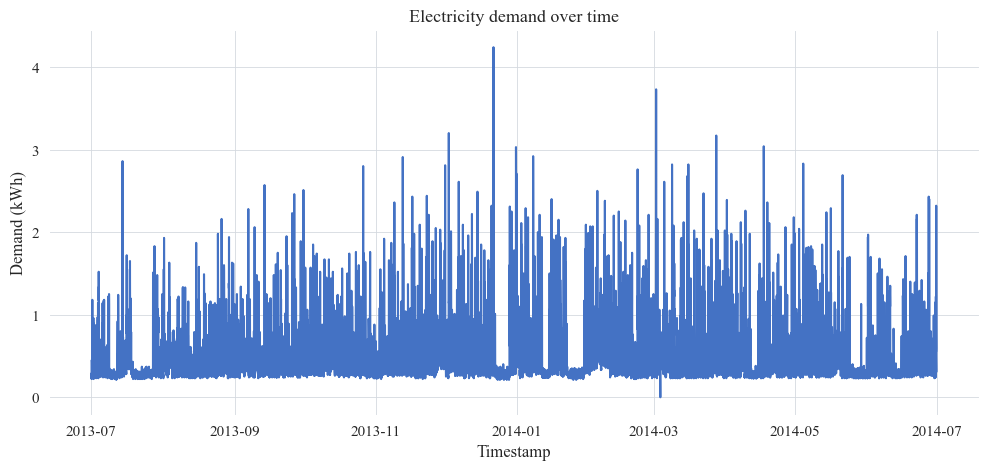

In [15]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(data=weather_data, x='timestamp', y='demand', color=ENERGY_COLORS['grid'])
plt.title("Electricity demand over time")
plt.xlabel("Timestamp")
plt.ylabel("Demand (kWh)")
save_fig(fig, "ex5_fig1_demand_over_time.svg")
plt.show()

## Figure 2. Demand vs weather pairwise relationships
I decided to use shortwave radiation as a general indicator of solar energy, because it combines both direct and diffuse sunlight, providing a simple measure of overall solar intensity without introducing strong correlations between multiple radiation variables.

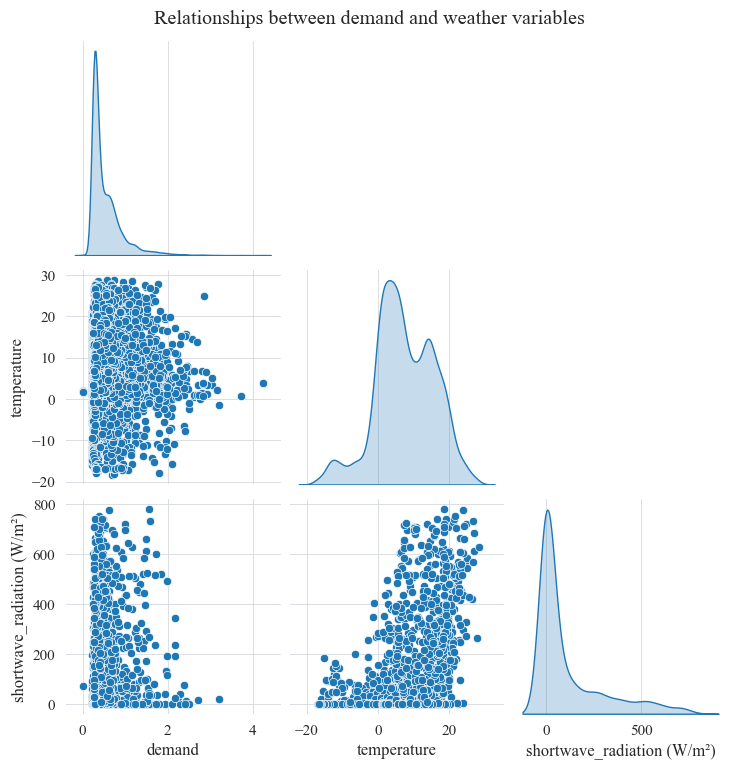

In [16]:
w_features = ['demand','temperature','shortwave_radiation (W/m²)']

g = sns.pairplot(
    weather_data[w_features],
    corner=True, diag_kind='kde'
)

plt.suptitle("Relationships between demand and weather variables", y=1.02)

fig = g.figure
save_fig(fig, "ex5_fig2_demand_vs_weather_pairwise.svg")

plt.show()

## Figure 3. Hourly demand profile

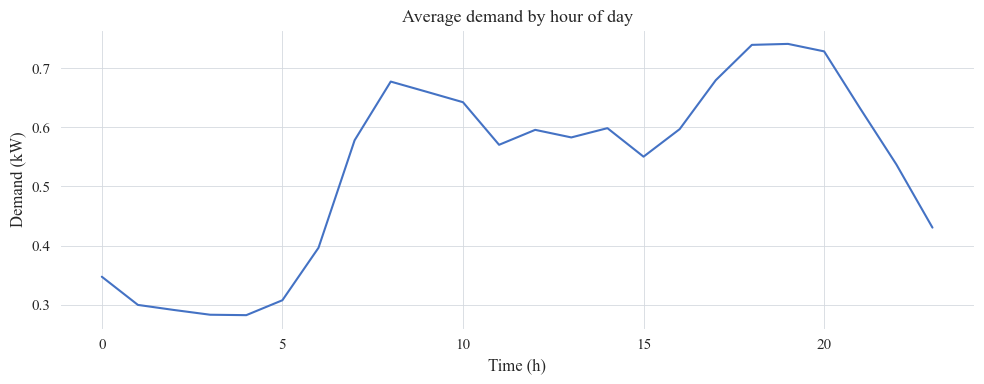

In [17]:
hour_profile = df['demand'].groupby(df.index.hour).mean()
hour_profile.index.name = 'hour'
hour_profile = hour_profile.reset_index()

fig, ax = plt.subplots()

ax.plot(
    hour_profile['hour'],
    hour_profile['demand'],
    color=ENERGY_COLORS['grid']
)

ax.set_title('Average demand by hour of day')
ax.set_xlabel('Time (h)')
ax.set_ylabel('Demand (kW)')

fig.tight_layout()
save_fig(fig, "ex5_fig3_hourly_demand_profile.svg")
plt.show()


---
## 2. Distribution analysis
In this step, I’m checking if the main numerical variables are normally distributed and whether they need any transformation.
Why does that matter? Because many models, especially regression, work best when the data (or at least the errors) follow a bell-shaped, Gaussian-like distribution.

I start by plotting histograms with KDE curves to quickly see the shape and symmetry of each variable. It’s a fast way to spot skewness or any major imbalances.

Then I run the Shapiro–Wilk test to back that up with numbers. If the p-value drops below 0.05, it’s a sign that the variable doesn’t follow a normal distribution.

For the variables that are strongly skewed, I use the Yeo–Johnson transformation. It’s flexible enough to handle zeros and even negative values, making it more robust than traditional methods like Box–Cox.

This transformation helps smooth out skewed data and makes things more Gaussian-like, which improves both the accuracy and reliability of later steps like correlation analysis and forecasting.

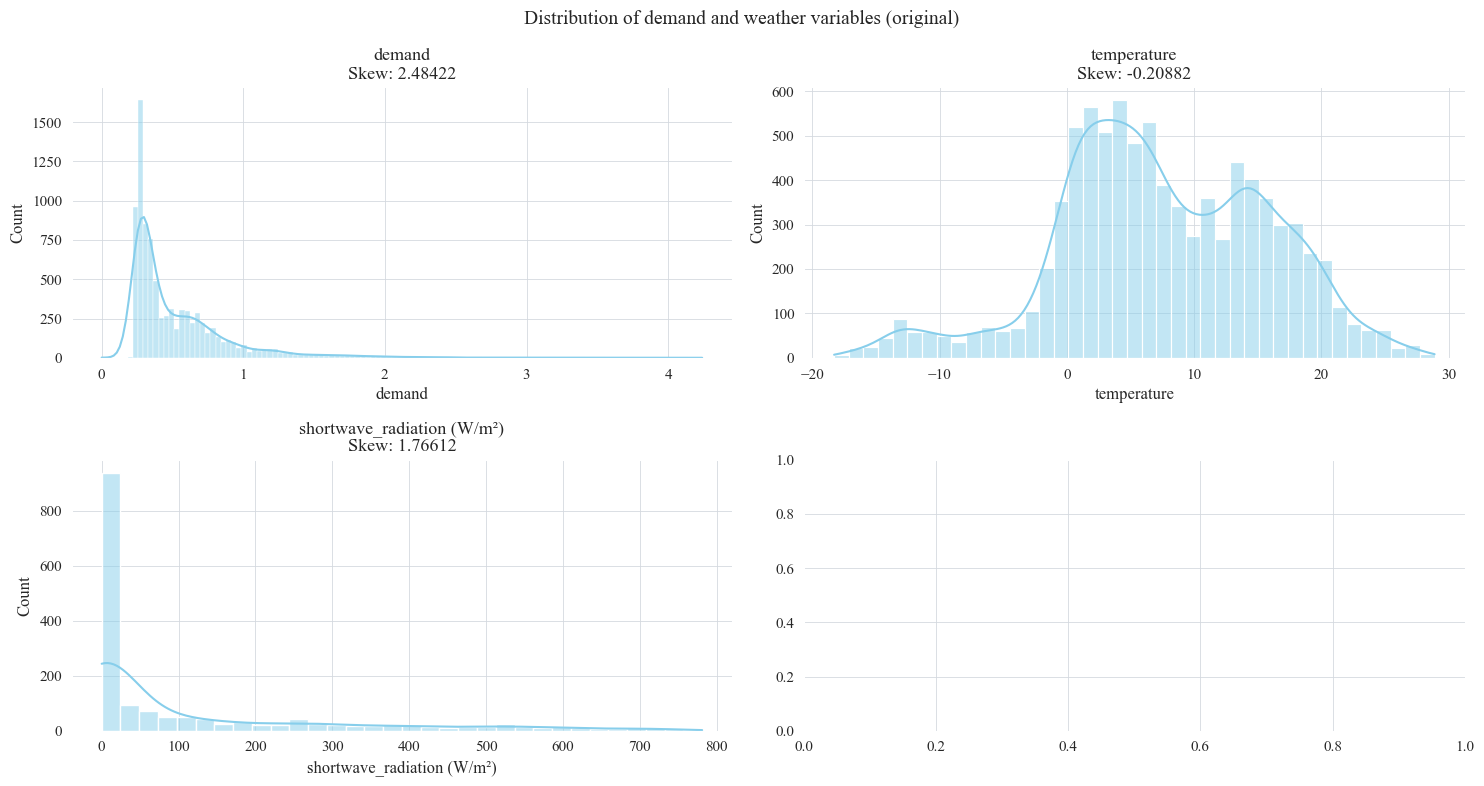

Shapiro–Wilk normality test results:

demand                         -> p-value = 0.0000, skew = 2.48422
temperature                    -> p-value = 0.0000, skew = -0.20882
shortwave_radiation (W/m²)     -> p-value = 0.0000, skew = 1.76612

Variables identified as non-normal: ['demand', 'temperature', 'shortwave_radiation (W/m²)']
Added transformed column: demand


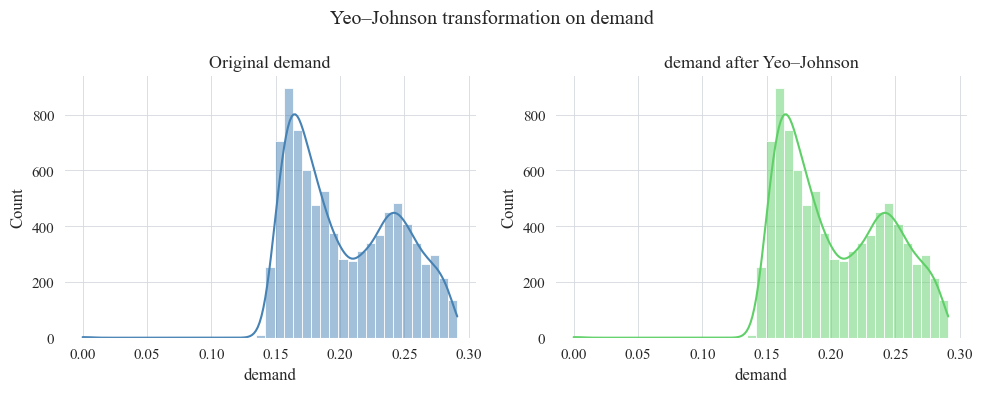

Added transformed column: temperature


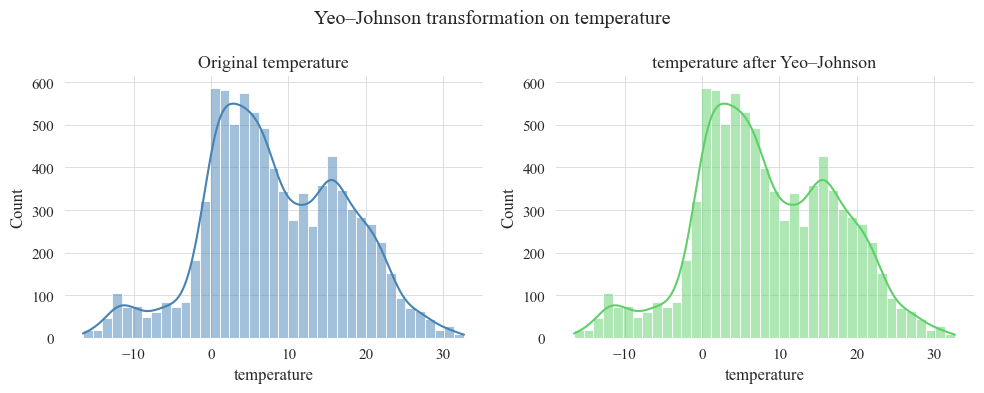

Added transformed column: shortwave_radiation (W/m²)


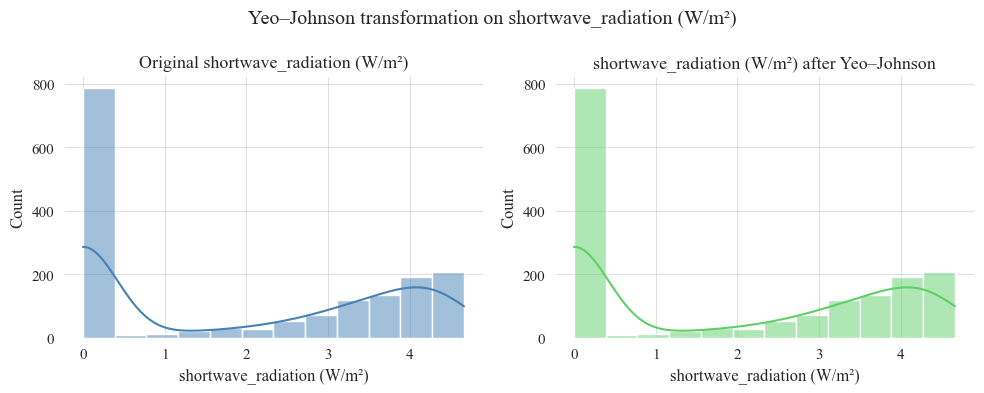

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(w_features):
    sns.histplot(weather_data[col].dropna(), kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f"{col}\nSkew: {weather_data[col].skew():.5f}")
plt.suptitle("Distribution of demand and weather variables (original)", fontsize=14)
plt.tight_layout()
plt.show()

print("Shapiro–Wilk normality test results:\n")
non_normal = []
for w in w_features:
    sample = weather_data[w].dropna().sample(min(5000, len(weather_data[w].dropna())), random_state=42)
    stat, p = shapiro(sample)
    skew_val = weather_data[w].skew()
    print(f"{w:30s} -> p-value = {p:.4f}, skew = {skew_val:.5f}")
    if (p < 0.05) or (abs(skew_val) > 1):
        non_normal.append(w)

print("\nVariables identified as non-normal:", non_normal)

transformer = PowerTransformer(method='yeo-johnson', standardize=False)
for c in non_normal:
    new_col = f"{c}"
    transformed = transformer.fit_transform(weather_data[[c]].dropna()).flatten()
    weather_data.loc[weather_data[c].notna(), new_col] = transformed
    print(f"Added transformed column: {new_col}")

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(weather_data[c].dropna(), kde=True, ax=ax[0], color='steelblue')
    sns.histplot(weather_data[new_col].dropna(), kde=True, ax=ax[1], color='#5FD068')
    ax[0].set_title(f"Original {c}")
    ax[1].set_title(f"{c} after Yeo–Johnson")
    plt.suptitle(f"Yeo–Johnson transformation on {c}")
    plt.tight_layout()
    plt.show()

To improve the shape of some skewed variables, I applied the Yeo–Johnson transformation to the ones that didn’t follow a normal distribution. Below, you see how each variable looked before and after the transformation.

## 3. Feature creation

In [19]:
features = df.copy()

features["hour"] = features.index.hour
features["weekday"] = features.index.dayofweek
features["is_weekend"] = (features["weekday"] >= 5).astype(int)
features['hour_sin'] = np.sin(2 * np.pi * features['hour'] / 24)
features['hour_cos'] = np.cos(2 * np.pi * features['hour'] / 24)
features['cooling_degree'] = np.clip(features['temperature'] - 18, 0, None)
features['heating_degree'] = np.clip(18 - features['temperature'], 0, None)

selected_features = ['demand','hour_sin', 'hour_cos', 'is_weekend', 'cooling_degree', 'heating_degree', 'temperature', 'pressure (hPa)', 'cloud_cover (%)', 'wind_speed_10m (km/h)', 'shortwave_radiation (W/m²)', 'direct_radiation (W/m²)', 'diffuse_radiation (W/m²)', 'direct_normal_irradiance (W/m²)']

features_table = features[selected_features].round(5)
save_table(features_table, "ex5_features_table.csv")

,demand,hour_sin,hour_cos,is_weekend,cooling_degree,heating_degree,temperature,pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²)
timestamp,,,,,,,,,,,,,,
2013-07-01 00:00:00+00:00,0.27,0.00000,1.00000,0,0.0,4.5,13.5,1011.3,4,10.5,NaN,0,0,0.0
2013-07-01 01:00:00+00:00,0.23,0.25882,0.96593,0,0.0,4.8,13.2,1010.8,27,11.9,0.0,0,0,0.0
2013-07-01 02:00:00+00:00,0.26,0.50000,0.86603,0,0.0,4.9,13.1,1010.3,33,11.6,0.0,0,0,0.0
2013-07-01 03:00:00+00:00,0.28,0.70711,0.70711,0,0.0,5.0,13.0,1010.3,28,11.2,NaN,2,7,30.1
2013-07-01 04:00:00+00:00,0.29,0.86603,0.50000,0,0.0,4.2,13.8,1010.2,16,11.7,NaN,30,31,252.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-30 19:00:00+00:00,2.32,-0.96593,0.25882,0,0.0,2.8,15.2,1007.2,100,11.8,NaN,47,110,142.9
2014-06-30 20:00:00+00:00,0.99,-0.86603,0.50000,0,0.0,3.2,14.8,1007.4,100,11.3,NaN,12,68,57.6
2014-06-30 21:00:00+00:00,0.50,-0.70711,0.70711,0,0.0,4.1,13.9,1007.5,96,10.2,NaN,5,30,45.1


---
## 4. Features ranking by relevance
We are going to evaluate which features are the most important for explaining variations in demand. To perform this, we train Random Forest Regressor, which can estimate feature importance based on how much each variable reduces prediction error

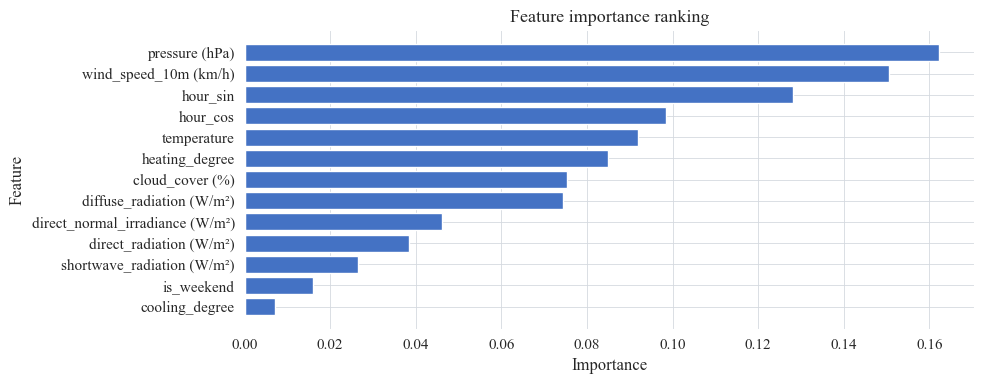

,feature,importance
6,pressure (hPa),0.162322
8,wind_speed_10m (km/h),0.150562
0,hour_sin,0.128072
1,hour_cos,0.098542
5,temperature,0.091867
4,heating_degree,0.084993
7,cloud_cover (%),0.075228
11,diffuse_radiation (W/m²),0.074385
12,direct_normal_irradiance (W/m²),0.046183
10,direct_radiation (W/m²),0.038406


In [22]:
academic_style()
clean = features.dropna(subset=["demand"])
X = clean[selected_features].drop(columns=["demand"])
y = clean["demand"]

rf = RandomForestRegressor(n_estimators=120, random_state=42)
rf.fit(X, y)

importance = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

fig, ax = plt.subplots()

ax.barh(
    importance["feature"],
    importance["importance"],
    color=ENERGY_COLORS["grid"]
)

ax.set_title("Feature importance ranking")
ax.set_xlabel("Importance")
ax.set_ylabel("Feature")

ax.invert_yaxis()  # et kõige olulisem oleks üleval

fig.tight_layout()
save_fig(fig, "ex5_fig4_feature_importance.svg")
plt.show()

display(importance)


## Conclusion
In our case, the most influential features are pressure (hPa), wind_speed_10m (km/h), and the hour_sin / hour_cos time-related variables.
Weather-driven variables (temperature) also score highly.
Lower-ranked features such as is_weekend and cooling_degree have weaker effects. Probably because their influence may appear only during some certain months, or they do not add much more additional information, because some of their information is already represented by other correlated variables.